# Midterm Assignment, topic 6: Static discrete choice

> The sequence of tasks below should be performed in order in this
notebook. Feel free to add code and markdown cells, but do not change
cells that contain the assignment tasks.
If the task offers some degree of interpretation (so, don’t tell you what
to do exactly), you are free to interpret it in the way you see fit
best. But remember to explain why you make such and such choice in your answer.

> The grade for the midterm assignment is based on both the code
correctness and code style. The former relates to whether the code
adequately represents the economic model under consideration, and the
latter has to do with how well the code is modularized and organized,
whether appropriate syntax is used, and whether the code is well
documented. [PEP 8](https://www.python.org/dev/peps/pep-0008/)
standard is a good reference for coding style, but will not reduce the
grade.

## Static discrete consumer choice

Consider the following setting.
A decision maker has to choose one of $ n $ alternatives, each
characterized by $ m $ attributes $ x_i = \big( x_{i,1},\dots,x_{i,m} \big) $,
$ i \in \{1,\dots,n\} $.
The decision maker is endowed with a utility function of the form

$$
U(x,\epsilon)=u(x) + \epsilon, \quad  U(x,\epsilon) : \mathbb{R}^{m+1}  \rightarrow \mathbb{R}
$$

Following the random utility modelling framework, we assume that the
decision maker is experiencing random utility shocks in the form of
$ \epsilon $ that have [Type I Extreme Value distribution
(EV)](https://en.wikipedia.org/wiki/Gumbel_distribution), and are
distributed independently between alternatives. CDF and the expectation
of the distribution is given by

$$
F(x)=\exp\big(-\exp(-\frac{x-\eta}{\sigma})\big), \quad \mathbb{E}(x)=\eta + \gamma \sigma, \; \gamma=0.5772
$$

Assuming the standard normalization $ \eta=0 $, we have
$ F(x)=\exp(-\exp(-x/\sigma)) $ and $ \mathbb{E}(x)=\gamma\sigma $.

The conditional choice probability, i.e. probability of choosing
alternative $ i $ is given by

$$
p_i = P\{U(x_i)\ge U(x_j) \text{ for all } j\ne i \} = P\{u(x_i) + \epsilon_i \ge \max_{j\ne i}U(x_j)\}
$$

Due to the max-stability property of EV distribution,
$ \max_{j\ne i}U(x_j) $ also has an EV(1) distribution with
location parameter given by what is called the *logsum function*
$ \sigma\log\sum_{j\ne i} \exp[u(x_j)/\sigma] $,
and the same scale $ \sigma $.
Then, using the fact that the difference of two EV distributed random variables
has a logistic distribution, we have

$$
p_i = P\{\max_{j\ne i}U(x_j) - \epsilon_i \le u(x_i) \}
= \big[ 1+\exp \big(\sigma\log\sum_{j\ne i} \exp[u(x_j)/\sigma] - u(x_i)/\sigma \big) \big]^{-1}
= \frac{\exp[u(x_i)/\sigma]}{\sum_{j=1}^{n} \exp[u(x_j)/\sigma]}
$$

### Task 1. Design and implement a Python class to represent the logit formula

Write the *init*, *repr* and other methods of the class to implement the
following logic:

- the fundamental parameters of the model, i.e. number of choices $ n $,
  number of attributes $ m $, scale parameter $ \sigma $,
  attributes of the alternatives $ x_{ij} $ (make sure they are stored as *floats*),
  and the deterministic part of the utility function $ u(x_1,\dots,x_m) $
  should be properties of the class  
- implement the standard *call* method to compute the vector of choice probabilities
  given by the  
- implement the *logsum* method that would return the logsum
  ($ \sigma\log\sum_{j\ne i} \exp[u(x_j)/\sigma] $) of the utilities of
  the alternatives given for the given fundamental parameters  
- implement the *plot* function that makes a chart of appropriate type to visualize
  the choice probabilities implied by the given fundamental parameters  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class logit:
    '''Class to represent a logit formula'''

    def __init__(self,X,u=None,sigma=1.0):
        '''Initialization of the logit class'''
        # attributes of the alternatives
        X = np.array(X,dtype=float) # make sure X is np array
        if X.ndim == 1:
            X = np.reshape(X,(X.size,1)) # make column vector if unidimensional
        self.X = X
        # main dimensions of the model
        self.n = X.shape[0] # number of alternatives
        self.m = X.shape[1] # number of attributes per alternative
        # scale parameter
        self.sigma = sigma
        # deterministic part of utility
        if u:
            self.util = u
        else:
            self.util = lambda x: x[0] # default utility is first attribute

    def __repr__(self):
        '''String representation of the object'''
        return 'Logit with n=%d m=%d, sigma=%1.1f'%(self.n,self.m,self.sigma)

    def __call__(self,stable=True):
        '''Call method to return the vector of logit choice probabilities'''
        v = np.apply_along_axis(self.util,1,self.X)
        v = v / self.sigma # scale the values of alternatives
        if stable: v -= np.amax(v) # subtract max for numerical stability
        expv = np.exp(v)
        sumexpv = expv.sum()
        return expv / sumexpv

    def logsum(self):
        '''Method to compute logsum of the choice problem'''
        v = np.apply_along_axis(self.util,1,self.X)/self.sigma
        vmax = np.amax(v)
        v -= vmax # subtract max for numerical stability
        sumexpv = np.exp(v).sum()
        return self.sigma * (vmax + np.log(sumexpv))

    def plot(self, show=False):
        '''Plot choice probabilities'''
        p = self()
        fig, ax = plt.subplots()
        y = np.arange(self.n)
        ax.barh(y, p,align='center',color='blue',alpha=0.6)
        ax.set_yticks(y)
        ax.set_yticklabels(['Alternative %d'%i for i in range(1,self.n+1)])
        ax.invert_yaxis()  # labels read top-to-bottom
        ax.set_xlabel('Choice probability')
        ax.set_title(self.__repr__())
        if show: plt.show()

Make sure the following tests pass:

In [2]:
import unittest
from scipy import optimize

class tests_logit(unittest.TestCase):
    """Tests for the logit class"""

    def test1(self):
        X = np.zeros((5,3)) # 5 alternatives, 3 attributes
        X[0,0]=np.log(3)
        m = logit(X,sigma=1.0)
        p = m()
        self.assertTrue(np.abs(p[1] - 0.14285714)  < 1e-5)

    def test2(self):
        X = np.zeros((5,3)) # 5 alternatives, 3 attributes
        X[0,0]=2.0
        X[4,2]=2.0
        util = lambda x: x[1]*x[0]+x[2]
        m = logit(X,sigma=1.0,u=util)
        p = m()
        self.assertTrue(np.abs(p[4] - 0.64878564)  < 1e-5)

    def test3(self):
        X = np.zeros((5,3)) # 5 alternatives, 3 attributes
        X[0,0]=2.0
        X[4,2]=2.0
        util = lambda x: x[1]*x[0]+x[2]
        m = logit(X,sigma=3.0,u=util)
        p = m()
        self.assertTrue(np.abs(p[0] - 0.16813126)  < 1e-5)

    def test4(self):
        X = [[1,2],[1,2],[3,0],]
        m = logit(X,sigma=3.0)
        p = m()
        self.assertTrue(np.abs(m.logsum() - 5.119425261443224)  < 1e-5)


# this is the way to run tests
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.004s

OK


### Task 2. Choice probabilities under different preferences

Consider the following set of alternatives each given with 3 attributes:

$$
\begin{eqnarray}
x_1 &=& (0,0,1) \\
x_2 &=& (0,2,1) \\
x_3 &=& (0,2,1) \\
x_4 &=& (1,0,1) \\
x_5 &=& (3,0,2)
\end{eqnarray}
$$

Make a plot of the choice probabilities under each of the following specifications
of the deterministic part of the utility function:

$$
\begin{eqnarray}
u^a(x) &=& \sum_i x_i \\
u^b(x) &=& \prod_i x_i \\
u^c(x) &=& \big(\prod_i \frac{1}{x_i+1} \big)^{-1}
\end{eqnarray}
$$

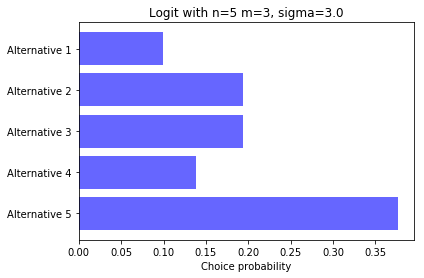

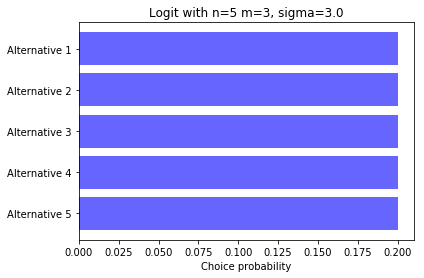

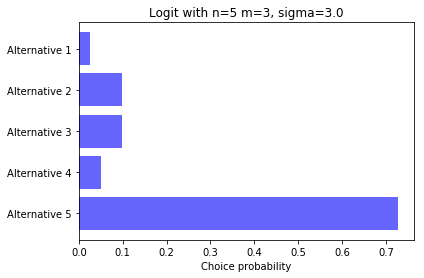

In [12]:
X =[[0,0,1],
    [0,2,1],
    [0,2,1],
    [1,0,1],
    [3,0,2],]

fun = [lambda x: x.sum(), \
       lambda x: x.prod(), \
       lambda x: 1/np.prod(1/(x+1)), ]

for f in fun:
    m = logit(X,sigma=3.0,u=f)
    m.plot()

### Task 3. Numerical stability of the logit formula

Attempt to compute the choice probabilities in the following example
for $ u(x_1,x_2) = log(x_1)^{x_2} $

$$
\begin{eqnarray}
x_1 &=& (102.4, 5.4) \\
x_2 &=& (105.0, 6.0) \\
x_3 &=& (103.5, 7.3) \\
x_4 &=& (103.2, 7.3) \\
x_5 &=& (103.5, 1.4)
\end{eqnarray}
$$

In [5]:
X = np.array([[102.4,105.0,103.5,103.2,103.5],[5.4,6.0,7.3,7.3,1.4]]).transpose()
l1 = logit(X,u=lambda x: np.log(x[0])**x[1])
print(l1(stable=True))
print(l1())

[0.00000000e+000 0.00000000e+000 1.00000000e+000 6.78049637e-146
 0.00000000e+000]
[0.00000000e+000 0.00000000e+000 1.00000000e+000 6.78049637e-146
 0.00000000e+000]


Do the computed choice probabilities sum up to one (like all choice probabilities should)?

- Modify the call method in your class using the following trick that makes the
  logit calculation numerically stable.  
- Make similar modification to the logsum method.  
- Make sure all the tests in Task 1 still pass  


Rewrite the program to
make it numerically stable using the following representation of logit
formula

$$
p_i=\frac{\exp\frac{u(x_i,y_i)}{\sigma}}{\sum_{j=1}^{n}\exp\frac{u(x_j,y_j)}{\sigma}} =
=\frac{\exp\big[\frac{u(x_i,y_i)}{\sigma}-M\big]}{\sum_{j=1}^{n}\exp\big[\frac{u(x_j,y_j)}{\sigma}-M\big]},\;\;
M=\max_{i}\frac{u(x_i,y_i)}{\sigma}
$$

### Task 4. Logit smoother and smoothed max function

Besides the implementation of the discrete choice model under a particular assumption
on the distribution of the stochastic part in the random utility model,
logit formula plays an important role as a computational tool to smooth out functions
with kinks and discontinuities.

Consider the following arbitrary function with a discontinuity

$$
f(z) = \sqrt{z} + z * \mathbb{1}\{z>1.5\}
$$

The indicator function inside of $ f(z) $ can be replaced by a logit choice
probability from a binary choice model with the attributes given by $ x_1=0 $ and
$ x_2=z-1.5 $, and with $ u(x)=x $ as the utility function.
The scale parameter $ \sigma $ then plays the role of the amount of smoothing,
and with $ \sigma \rightarrow 0 $ the smoothed function approaches the original $ f(z) $.

- Implement this scheme in the code using the logit class  
- Plot the original function $ f(z) $, and three smooth approximations for
  $ \sigma = \{0.5,0.25,0.125,0.05\} $  

Text(0.5, 1.0, 'Logit smoothing')

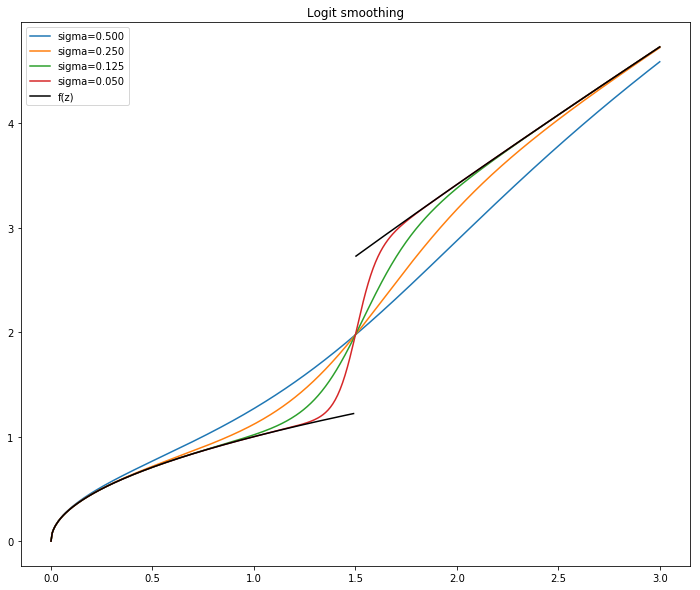

In [6]:
fun = lambda z: np.sqrt(z) + z * (z>1.5) # original function
# smoothed approximation
lgt = logit(np.array([[1.0],[0.0]])) # create logit object just once, use default u(x)
def smooth(z,sigma=1.0):
    '''smooth approximation using logit smoother'''
    lgt.sigma = sigma # udate sigma
    res = np.empty(z.shape)
    for i in range(z.size):
        lgt.X[0,0] = z[i]-1.5 # update the attribute
        res[i] = np.sqrt(z[i]) + z[i] * lgt()[0]
    return res.reshape(z.shape)
# make a plot
xgrid = np.linspace(0,3,500)
j = np.argwhere(xgrid<1.5)[-1] # index for nan insertion to get discontinuety
fgrid = fun(xgrid)
fgrid[j] = np.nan
fig, ax = plt.subplots(figsize=(12,10))
for s in [0.5,0.25,0.125,0.05]:
    sgrid = smooth(xgrid,s)
    ax.plot(xgrid,sgrid,label='sigma=%1.3f'%s)
ax.plot(xgrid,fgrid,color='black',label='f(z)')
ax.legend()
ax.set_title('Logit smoothing')

Similarly, the logsum function is sometimes referred to as *smoothed max*.  Consider
to functions $ g_1(w) = 10\sqrt{w} $ and $ g_2(w) = \exp(w+2)-10 $.
Their upper envelope

$$
f(w) = \max \{ g_1(w), g_2(w)\} = \max \{ 10\sqrt{w}, \exp(w+2)-10\}
$$

has a kink at the point $ w $ that solves $ 10\sqrt{w} = \exp(w+2)-10 $.
Smooth approximation to the function $ f(w) $ is given by

$$
\tilde{f}(w) = \text{logsum} \big( g_1(w), g_2(w), \sigma \big) =
\sigma \log \big( \exp \frac{10\sqrt{w}}{\sigma} + \exp\frac{\exp(w+2)-10}{\sigma} \big)
$$

where $ \sigma $ again plays the role of smoothing parameter, and it holds
$ \tilde{f}(w) \rightarrow f(w) $ when $ \sigma \rightarrow 0 $.

- Implement this scheme in the code using the logit class  
- Plot the original function $ f(w) $, and three smooth approximations for
  $ \sigma = \{5.0,2.5,1.0,0.5\} $ (use grid on x axes between 0 and 2.0)  

Text(0.5, 1.0, 'Logit smoothing')

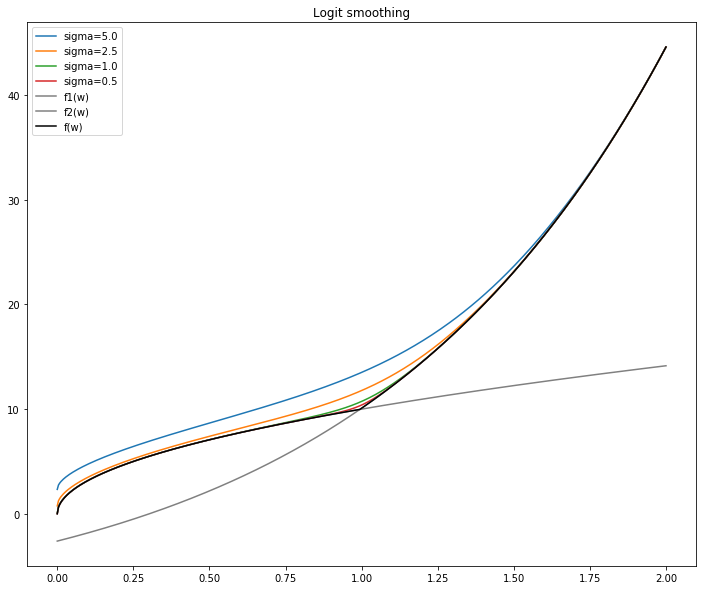

In [6]:
f1 = lambda w: 10*np.sqrt(w)
f2 = lambda w: np.exp(w+2)-10
f = lambda w: np.maximum(f1(w),f2(w))
# smoothed approximation
lgt = logit(np.array([[1.0],[0.0]])) # create logit object just once, use default u(x)
def smoothmax(w,sigma=1.0):
    '''smooth approximation using logit smoother'''
    lgt.sigma = sigma # udate sigma
    res = np.empty(w.shape)
    for i in range(w.size):
        lgt.X[0,0] = f1(w[i]) # update attribute 1
        lgt.X[1,0] = f2(w[i]) # update attribute 2
        res[i] = lgt.logsum()
    return res.reshape(w.shape)
# make a plot
xgrid = np.linspace(0,2,500)
fig, ax = plt.subplots(figsize=(12,10))
for s in [5.0,2.5,1.0,0.5]:
    sgrid = smoothmax(xgrid,s)
    ax.plot(xgrid,sgrid,label='sigma=%1.1f'%s)
ax.plot(xgrid,f1(xgrid),color='grey',label='f1(w)')
ax.plot(xgrid,f2(xgrid),color='grey',label='f2(w)')
ax.plot(xgrid,f(xgrid),color='black',label='f(w)')
ax.legend()
ax.set_title('Logit smoothing')

### Task 5. Blue/red bus problem, IIA and nested logit model

Logit model is often criticized for the property called independence of irrelevant alternatives (IIA).
This property states that the ratio between any two choice probabilities should be independent of the attributes of the alternatives other than the two considered.

Even though this does not sound too bad, the implication of IIA is that when one alternative
becomes more attractive, the increase of probability to choose it leads to a decrease in all
other choice probabilities *proportional to their initial values*.
Stated that way, it is easy to see that IIA implies an unrealistically simple
model.  In the real world, products compete unequally with one another and
when an existing product is improved, it usually gains most from a subset of
products with which it competes most directly.

Consider the classic blue/red bus problem.
Imagine a transportation market with two products, cars and red buses, each
having a market share of 50%.  Suppose we add a second bus, colored blue.  An
IIA simulator would predict that the blue bus would take share equally from
the car and red bus, so that the total bus share would become 67%.  But it’s
clearly more reasonable to expect that the blue bus would take share mostly
from the red bus, and that total bus share would remain close to 50%.

An alternative more realistic model is a nested logit model.  The idea is that
the choice is made is several stages: first, between cars and busses, and in case busses are
chosen, between blue and red busses.  Mathematically, with nested logit, the choice
probability for each individual alternative is a product of choosing the group (nest) where
this alternative belongs, times the probability of choosing the alternative within the nest.
It is also easy to generalize this scheme to the multiple stages.

Using the logit class, replicate the blue/red bus problem, assuming the following.
Assume that the decision maker prefers the red bus out of the three options, and ranks car as
least attractive.  Set $ u(\text{red bus})=3 $, $ u(\text{blue bus})=2.5 $,
$ u(\text{car})=1 $. Complete the following steps:

- Using standard logit model, first, compute the choice probabilities in the choice set that only has blue bus and the car  
- Second, introduce the red bus into the choice set, and compute the change in probability of choosing the mode of transport (bus or car)  
- Next, build the nested logit model.  To achieve this, set the utility of choosing bus in the first
  stage equal to the logsum of the second stage choice between buses of different color. Further, to
  reflect that second stage choice is easier due to reduced number of alternatives compared to the
  full set, set sigma scale parameter on the second stage 0.2 instead of default 1.0.
  Repeat the calculation of the effect of adding the red bus to the choice set.  

In [13]:
red, blue, car = 3., 2.5, 1 # underlying utilities
m1 = logit([blue,car])
m2 = logit([blue,red,car])
m3b = logit([blue,red],sigma=0.2)
m3a = logit([m3b.logsum(),car])

print('Standard logit, 2 choices (baseline)')
print('P(bus) = P(blue bus) =',m1()[0])
print('P(car) =',m1()[1])

print('\nStandard logit, 3 choices')
print('P(blue bus) =',m2()[0])
print('P(red bus) =',m2()[1])
print('P(bus) =',m2()[0]+m2()[1],'change =',m2()[0]+m2()[1]-m1()[0])
print('P(car) =',m2()[2],'change =',m2()[2]-m1()[1])

print('\nNested logit 3 choices')
print('P(blue bus) =',m3b()[0]*m3a()[0])
print('P(red bus) =',m3b()[1]*m3a()[0])
print('P(bus) =',m3a()[0],'change =',m3a()[0]-m1()[0])
print('P(car) =',m3a()[1],'change =',m3a()[1]-m1()[1])

Standard logit, 2 choices (baseline)
P(bus) = P(blue bus) = 0.8175744761936437
P(car) = 0.18242552380635632

Standard logit, 3 choices
P(blue bus) = 0.3482074278837349
P(red bus) = 0.5740969929676946
P(bus) = 0.9223044208514295 change = 0.10472994465778585
P(car) = 0.0776955791485706 change = -0.10472994465778572

Nested logit 3 choices
P(blue bus) = 0.06694057560195796
P(red bus) = 0.8155031579968671
P(bus) = 0.882443733598825 change = 0.06486925740518135
P(car) = 0.11755626640117497 change = -0.06486925740518135
